In [1]:
# Mengimpor library
import re

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

from joblib import Parallel
from joblib import delayed

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, cohen_kappa_score, ConfusionMatrixDisplay

## Data Understanding

In [2]:
# membaca data dari file CSV
df = pd.read_csv(r'../datasets/imdb-reviews-50k.csv.gz')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<AxesSubplot:>

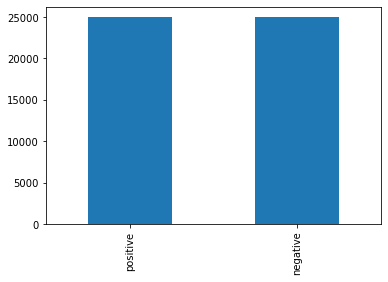

In [3]:
# Menghitung banyaknya data untuk setiap kelas
df["sentiment"].value_counts().plot(kind="bar")

## Data Preparation

In [4]:
# Menyiapkan format bahasa dan mengunduh dictionary
nltk.download(['stopwords', 'punkt'])

# Kumpulan stopwords
stopwords_list = set(stopwords.words('english') + ['AT_USER', 'URL'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/fahmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/fahmi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Fungsi untuk melakukan pembersihan teks
def preprocess_text(text):
    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'AT_USER', text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords_list and word.isalpha()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if len(word) > 2]
    return ' '.join(tokens)

In [6]:
y = df["sentiment"].values
X = Parallel(n_jobs=8, batch_size=128, verbose=10)(delayed(preprocess_text)(text) for text in df["review"].values)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 1168 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 2064 tasks      | elapsed:    3.2s
[Parallel(n_jobs=8)]: Done 3216 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done 4368 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 5776 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 7184 tasks      | elapsed:    4.7s
[Parallel(n_jobs=8)]: Done 8848 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done 10512 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 12432 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done 14352 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 16528 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done 18704 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done 21136 tasks      | elapsed:

[('movie', 99849), ('film', 90372), ('one', 53623), ('like', 40139), ('time', 29633)]


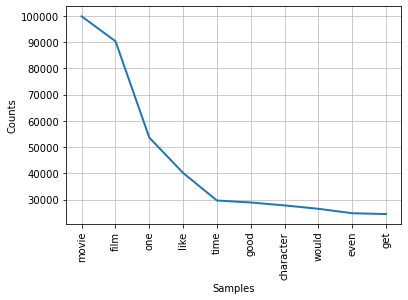

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [7]:
# Membuat korpus kata-kata umum
freqdist = FreqDist()
for sentence in X:
    for word in word_tokenize(sentence):
        freqdist[word] += 1

# Visualisasi kata-kata umum
print(freqdist.most_common(5))
freqdist.plot(10, cumulative=False)

In [8]:
# Membagi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [9]:
# Fungsi untuk mengubah id 4 menjadi 1 dan sisanya 0
lb = LabelEncoder()

y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

## Modelling

In [10]:
# Membuat model
classifier = Pipeline([
    ('tfidf', TfidfVectorizer(use_idf=True)),
    ('clf', MultinomialNB())
])

classifier.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

## Evaluation

In [11]:
# Melakukan prediksi menggunakan data uji
y_pred = classifier.predict(X_test)

print("Kappa score:", cohen_kappa_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=lb.classes_))

Kappa score: 0.7263030303030302
              precision    recall  f1-score   support

    negative       0.85      0.88      0.87      8250
    positive       0.87      0.85      0.86      8250

    accuracy                           0.86     16500
   macro avg       0.86      0.86      0.86     16500
weighted avg       0.86      0.86      0.86     16500



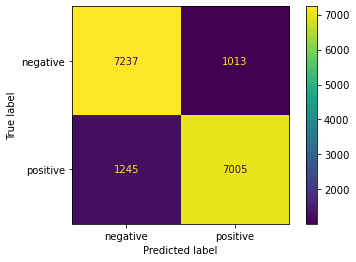

In [12]:
# Membuat confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=lb.classes_)

In [13]:
# Lakukan pediksi satu kalimat
pred_text = ["this painting is excellent", "you're horrible person!"]
pred_input = [preprocess_text(x) for x in pred_text]

# Prediksi kelas
predictions = classifier.predict(pred_input)
predictions_classes = lb.inverse_transform(predictions)

for text, sentiment in zip(pred_text, predictions_classes):
    print(text, "=", sentiment)

this painting is excellent = positive
you're horrible person! = negative
